In [12]:
import scanpy as sc
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.sparse
import random
import os

# Set working directory
os.chdir("P:/Tolulope/Manuscript/Yuan Analysis")
adata = sc.read_h5ad('integratedssssss.h5ad')
adata

AnnData object with n_obs × n_vars = 45833 × 37912
    obs: 'batch', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'Sample', '_scvi_batch', '_scvi_labels', 'leiden', '_scvi_raw_norm_scaling', 'cell type', 'condition'
    var: 'n_cells'
    uns: 'Sample_colors', '_scvi_manager_uuid', '_scvi_uuid', 'cell type_colors', 'leiden', 'leiden_colors', 'log1p', 'markers', 'neighbors', 'rank_genes_groups', 'scvi_markers', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [13]:
import pandas as pd
import numpy as np
import scanpy as sc
import random
import matplotlib.pyplot as plt
import seaborn as sns
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

# -------------------- Pseudobulk Preparation --------------------
# Subset to Dendritic cells only
cell_subset = adata[adata.obs['cell type'] == 'Dendritic cells']

# Create pseudo-replicates
pbs = []
for sample in cell_subset.obs.Sample.unique():
    samp_cell_subset = cell_subset[cell_subset.obs['Sample'] == sample]
    samp_cell_subset.X = samp_cell_subset.layers['counts']  # Use raw counts

    indices = list(samp_cell_subset.obs_names)
    random.shuffle(indices)
    indices = np.array_split(np.array(indices), 4)  # Adjust for desired number of pseudo-reps

    for i, pseudo_rep in enumerate(indices):
        rep_adata = sc.AnnData(
            X=samp_cell_subset[pseudo_rep].X.sum(axis=0),
            var=samp_cell_subset[pseudo_rep].var[[]]
        )
        rep_adata.obs_names = [sample + '_' + str(i)]
        rep_adata.obs['condition'] = samp_cell_subset.obs['condition'].iloc[0]
        rep_adata.obs['replicate'] = i
        pbs.append(rep_adata)

# Combine pseudobulk replicates
pb = sc.concat(pbs)



In [14]:
counts = pd.DataFrame(pb.X, columns=pb.var_names)  # Convert to DataFrame

# Create DeseqDataSet object with pseudo-replicates
dds = DeseqDataSet(
    counts=counts,
    metadata=pb.obs,
    design_factors=['condition', 'replicate']
)

# Filter genes with low expression
sc.pp.filter_genes(dds, min_cells=1)

# Perform DESeq2 analysis
dds.deseq2()

# Run the Wald test and get results for condition contrast
stat_res = DeseqStats(dds, contrast=('condition', 'ASham-GFP', 'ASham-noGFP'))

# Get the summary of the results (check if this produces a DataFrame)
summary_output = stat_res.summary()
print(type(summary_output))  # This should be a DataFrame
if isinstance(summary_output, pd.DataFrame):
    print(summary_output.head())  # Show the first few rows to inspect

Fitting size factors...
Fitting dispersions...
... done in 1.69 seconds.

Fitting MAP dispersions...
... done in 2.66 seconds.

Fitting dispersions...
... done in 2.15 seconds.

Fitting MAP dispersions...
... done in 2.62 seconds.

Fitting dispersions...
... done in 2.00 seconds.

Fitting MAP dispersions...
... done in 3.17 seconds.

Fitting dispersions...
... done in 1.19 seconds.

Fitting MAP dispersions...
... done in 3.39 seconds.

Fitting dispersions...
... done in 1.26 seconds.

Fitting MAP dispersions...
... done in 2.94 seconds.

Fitting dispersions...
... done in 1.14 seconds.

Fitting MAP dispersions...
... done in 3.11 seconds.

Fitting dispersions...
... done in 1.30 seconds.

Fitting MAP dispersions...
... done in 2.76 seconds.

Fitting dispersions...
... done in 1.17 seconds.

Fitting MAP dispersions...
... done in 2.82 seconds.

Fitting dispersions...
... done in 1.11 seconds.

Fitting MAP dispersions...
... done in 2.93 seconds.

Fitting dispersions...
... done in 1.28 

Log2 fold change & Wald test p-value: condition ASham-GFP vs ASham-noGFP
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Pcmtd1              2.897922        0.136416  0.964347  0.141460  0.887507   
Exo1                0.067421        3.306892  4.108918  0.804808  0.420930   
Uxs1                3.043306        1.209050  0.900137  1.343185  0.179212   
Cdh19               0.004508        4.965451  6.235625  0.796304  0.425856   
Dsel                0.076641        2.939567  2.116431  1.388927  0.164855   
...                      ...             ...       ...       ...       ...   
ENSMUSG00000144196  0.932814        0.537616  1.264191  0.425265  0.670644   
ENSMUSG00000079808  0.016783        5.707664  5.449604  1.047354  0.294936   
ENSMUSG00000095041  0.776836       -0.248540  1.413481 -0.175835  0.860423   
ENSMUSG00000144201  0.249684        2.623323  2.092538  1.253656  0.209967   
Gfp                 0.001687        5.818274  6.308589  0.922278  0.3

... done in 0.87 seconds.



In [21]:
stat_res.summary()

Log2 fold change & Wald test p-value: condition ASham-GFP vs ASham-noGFP
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Pcmtd1              2.897922        0.136416  0.964347  0.141460  0.887507   
Exo1                0.067421        3.306892  4.108918  0.804808  0.420930   
Uxs1                3.043306        1.209050  0.900137  1.343185  0.179212   
Cdh19               0.004508        4.965451  6.235625  0.796304  0.425856   
Dsel                0.076641        2.939567  2.116431  1.388927  0.164855   
...                      ...             ...       ...       ...       ...   
ENSMUSG00000144196  0.932814        0.537616  1.264191  0.425265  0.670644   
ENSMUSG00000079808  0.016783        5.707664  5.449604  1.047354  0.294936   
ENSMUSG00000095041  0.776836       -0.248540  1.413481 -0.175835  0.860423   
ENSMUSG00000144201  0.249684        2.623323  2.092538  1.253656  0.209967   
Gfp                 0.001687        5.818274  6.308589  0.922278  0.3

Available genes in the dataset: ['Atp5f1a', 'Atp5f1b', 'Ndufs8', 'Cox4i1']
     Condition     Gene  Expression
0    YSham-GFP  Atp5f1a    1.780832
1  YSham-noGFP  Atp5f1a    1.224171
2  YSham-noGFP  Atp5f1a    0.000000
3  YSham-noGFP  Atp5f1a    0.831868
4  YSham-noGFP  Atp5f1a    0.963058
Number of rows in plot_data: 4236


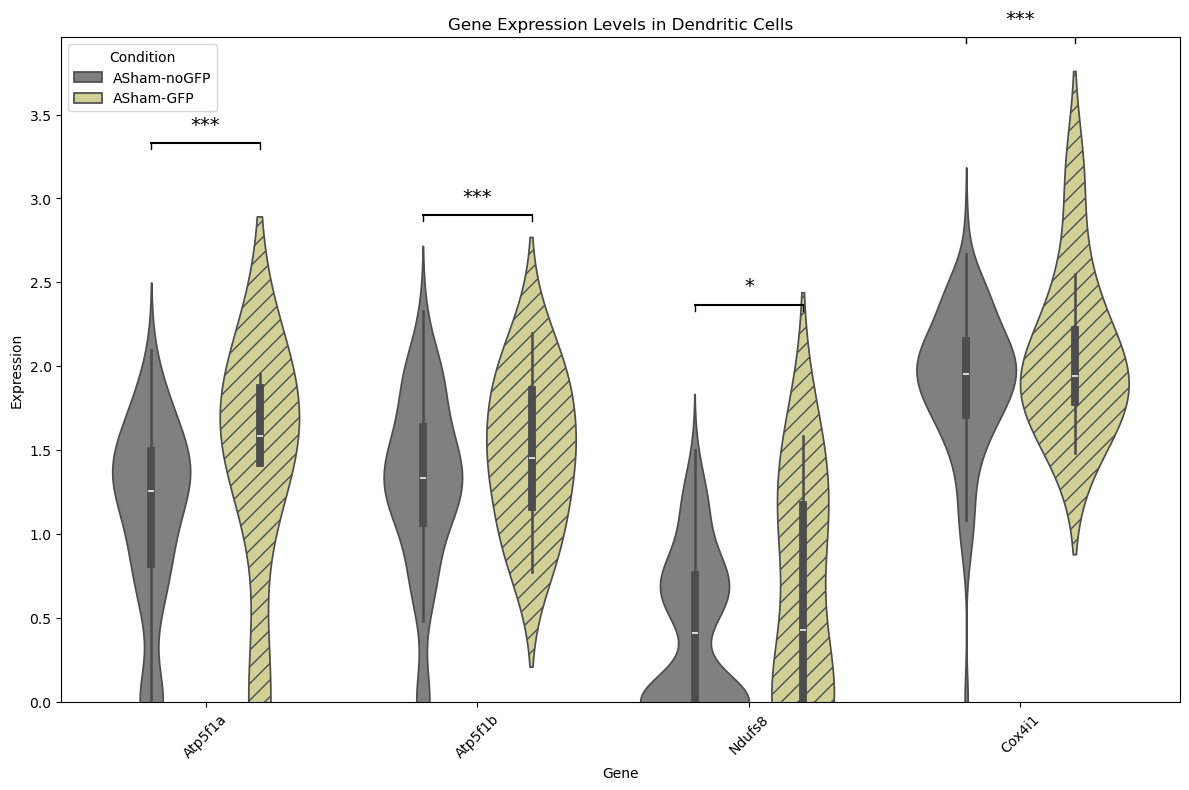

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse

# List of genes of interest
genes_of_interest = ['Atp5f1a', 'Atp5f1b', 'Ndufs8', 'Cox4i1']

# Filter to include only genes present in the dataset
available_genes = [gene for gene in genes_of_interest if gene in cell_subset.raw.var_names]
print(f"Available genes in the dataset: {available_genes}")

# Raise error if none are found
if not available_genes:
    raise ValueError("None of the genes of interest are present in the dataset.")

# Extract expression matrix from .raw
expr_matrix = cell_subset.raw.X.toarray() if scipy.sparse.issparse(cell_subset.raw.X) else cell_subset.raw.X

# Create a DataFrame for plotting
data = []
for gene in available_genes:
    gene_index = cell_subset.raw.var_names.get_loc(gene)
    gene_expr = expr_matrix[:, gene_index]
    data.append(pd.DataFrame({
        'Condition': cell_subset.obs['condition'].values,
        'Gene': gene,
        'Expression': gene_expr
    }))

plot_data = pd.concat(data, ignore_index=True)

# Debugging
print(plot_data.head())
print(f"Number of rows in plot_data: {len(plot_data)}")

# Raise error if DataFrame is empty
if plot_data.empty:
    raise ValueError("The plot_data DataFrame is empty. Check the gene extraction and subsetting steps.")

# Sort results from stat_res by the 'stat' column in descending order
de = stat_res.results_df
de = de.sort_values('stat', ascending=False)

# Set color palette for the conditions
palette = {'ASham-noGFP': 'gray', 'ASham-GFP': '#dbdb8d'}

# Plot violin plot
plt.figure(figsize=(12, 8))
ax = sns.violinplot(
    x='Gene',
    y='Expression',
    hue='Condition',
    data=plot_data,
    palette=palette,
    inner='box',
    hue_order=['ASham-noGFP', 'ASham-GFP']
)

# Apply hatch pattern only to ASham-GFP violins
for i, artist in enumerate(ax.collections):
    if i % 2 == 1:  # ASham-GFP (2nd hue in each gene group)
        artist.set_hatch('//')

# Annotate statistical significance
max_expr = plot_data['Expression'].max()
line_spacing = max_expr * 0.1
tick_height = max_expr * 0.01
text_offset = max_expr * 0.015

# Add annotations with p-values for each gene
for i, gene in enumerate(available_genes):
    # Get p-value from stat_res.summary() for the gene
    if gene in de.index:
        padj = de.loc[gene, 'padj']
    else:
        padj = 1.0  # Default to no significance if the gene is not found
    
    # Handle NaN values in padj
    if pd.isna(padj):
        padj = 1.0  # If padj is NaN, consider it not significant
    
    # Assign significance symbol based on p-value thresholds
    symbol = '***' if padj < 0.001 else '**' if padj < 0.01 else '*' if padj < 0.05 else 'ns'
    
    # Position the annotation above the maximum expression for each gene
    y = plot_data[plot_data['Gene'] == gene]['Expression'].max() + line_spacing
    x1, x2 = i - 0.2, i + 0.2  # X-axis positions for the comparison
    ax.plot([x1, x2], [y, y], color='black', linewidth=1.5)  # Line for significance
    ax.plot([x1, x1], [y, y - tick_height], color='black', linewidth=1)  # Left tick
    ax.plot([x2, x2], [y, y - tick_height], color='black', linewidth=1)  # Right tick
    ax.text((x1 + x2) / 2, y + text_offset, symbol, ha='center', va='bottom', fontsize=14)

# Axis settings
plt.ylim(0, plot_data['Expression'].max() * 1.1)
plt.title('Gene Expression Levels in Dendritic Cells')
plt.xticks(rotation=45)

# Order legend
handles, labels = plt.gca().get_legend_handles_labels()
order = ['ASham-noGFP', 'ASham-GFP']
ordered_handles = [handles[labels.index(cond)] for cond in order]
plt.legend(ordered_handles, order, title='Condition')

# Save and display plot
plt.tight_layout()
plt.savefig('Violin_ASham1.png')
plt.show()


Available genes in the dataset: ['Atp5f1a', 'Ndufs7', 'Ndufa9', 'Atp5f1c']
     Condition     Gene  Expression
0    YSham-GFP  Atp5f1a    1.780832
1  YSham-noGFP  Atp5f1a    1.224171
2  YSham-noGFP  Atp5f1a    0.000000
3  YSham-noGFP  Atp5f1a    0.831868
4  YSham-noGFP  Atp5f1a    0.963058
Number of rows in plot_data: 4236


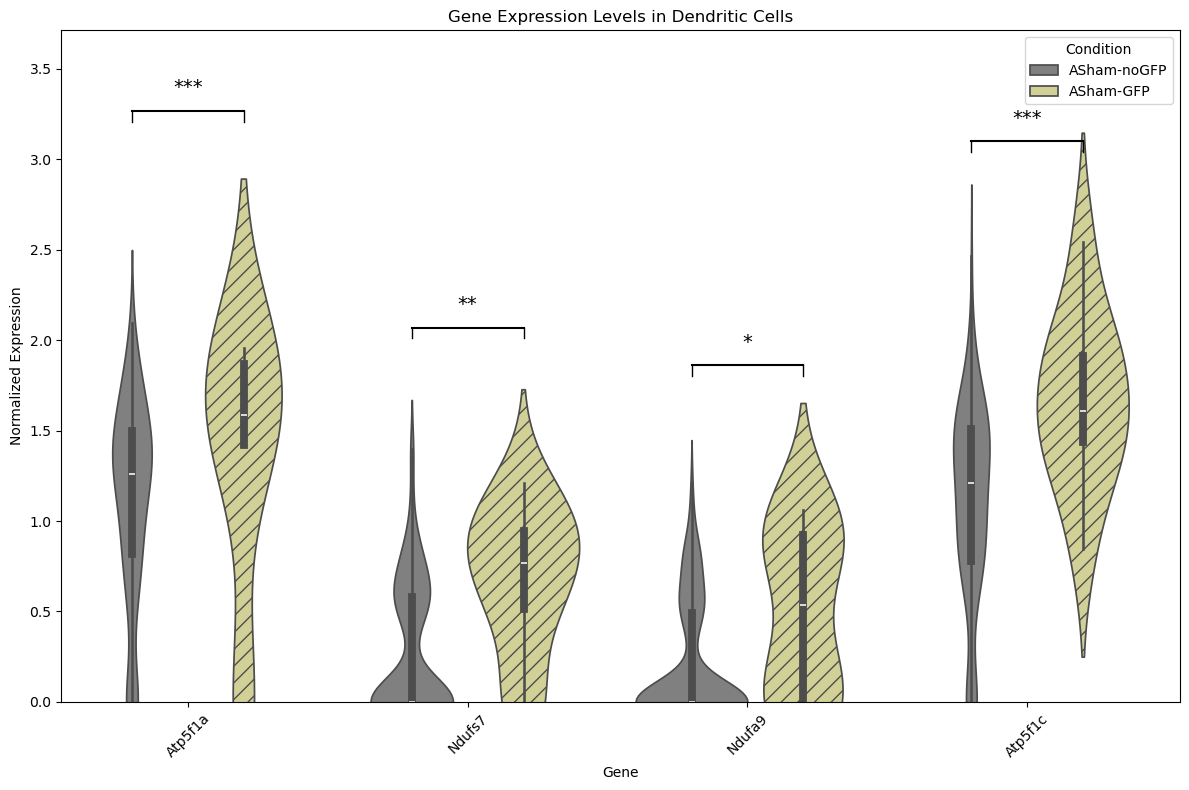

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse

# List of genes of interest
genes_of_interest = ['Atp5f1a', 'Ndufs7', 'Ndufa9', 'Atp5f1c']

# Filter to include only genes present in the dataset
available_genes = [gene for gene in genes_of_interest if gene in cell_subset.raw.var_names]
print(f"Available genes in the dataset: {available_genes}")

# Raise error if none are found
if not available_genes:
    raise ValueError("None of the genes of interest are present in the dataset.")

# Extract expression matrix from .raw
expr_matrix = cell_subset.raw.X.toarray() if scipy.sparse.issparse(cell_subset.raw.X) else cell_subset.raw.X

# Create a DataFrame for plotting
data = []
for gene in available_genes:
    gene_index = cell_subset.raw.var_names.get_loc(gene)
    gene_expr = expr_matrix[:, gene_index]
    data.append(pd.DataFrame({
        'Condition': cell_subset.obs['condition'].values,
        'Gene': gene,
        'Expression': gene_expr
    }))

plot_data = pd.concat(data, ignore_index=True)

# Debugging
print(plot_data.head())
print(f"Number of rows in plot_data: {len(plot_data)}")

# Raise error if DataFrame is empty
if plot_data.empty:
    raise ValueError("The plot_data DataFrame is empty. Check the gene extraction and subsetting steps.")

# Sort results from stat_res by the 'stat' column in descending order
de = stat_res.results_df
de = de.sort_values('stat', ascending=False)

# Set color palette for the conditions
palette = {'ASham-noGFP': 'gray', 'ASham-GFP': '#dbdb8d'}

# Plot violin plot
plt.figure(figsize=(12, 8))
ax = sns.violinplot(
    x='Gene',
    y='Expression',
    hue='Condition',
    data=plot_data,
    palette=palette,
    inner='box',
    hue_order=['ASham-noGFP', 'ASham-GFP']
)

# Apply hatch pattern only to ASham-GFP violins
for i, artist in enumerate(ax.collections):
    if i % 2 == 1:  # ASham-GFP (2nd hue in each gene group)
        artist.set_hatch('//')

# Annotate statistical significance
max_expr = plot_data['Expression'].max()
line_spacing = max_expr * 0.1  # Increase the line spacing to ensure it's above the bar
tick_height = max_expr * 0.02
text_offset = max_expr * 0.025

# Add annotations with p-values for each gene
for i, gene in enumerate(available_genes):
    # Get p-value from stat_res.summary() for the gene
    if gene in de.index:
        padj = de.loc[gene, 'padj']
    else:
        padj = 1.0  # Default to no significance if the gene is not found
    
    # Handle NaN values in padj
    if pd.isna(padj):
        padj = 1.0  # If padj is NaN, consider it not significant
    
    # Assign significance symbol based on p-value thresholds
    symbol = '***' if padj < 0.001 else '**' if padj < 0.01 else '*' if padj < 0.05 else 'ns'
    
    # Position the annotation just above the maximum expression
    y = plot_data[plot_data['Gene'] == gene]['Expression'].max() + line_spacing

    # Ensure that the annotation stays within the plot limits
    if y > max_expr * 1.2:  # Prevent annotation from going too high
        y = max_expr * 1.2

    x1, x2 = i - 0.2, i + 0.2  # X-axis positions for the comparison
    ax.plot([x1, x2], [y, y], color='black', linewidth=1.5)  # Line for significance
    ax.plot([x1, x1], [y, y - tick_height], color='black', linewidth=1)  # Left tick
    ax.plot([x2, x2], [y, y - tick_height], color='black', linewidth=1)  # Right tick
    ax.text((x1 + x2) / 2, y + text_offset, symbol, ha='center', va='bottom', fontsize=14)

# Axis settings
plt.ylim(0, plot_data['Expression'].max() * 1.25)  # Adjust ylim to accommodate annotations
plt.title('Gene Expression Levels in Dendritic Cells')
plt.xticks(rotation=45)

# Set y-axis label to reflect normalized expression
plt.ylabel('Normalized Expression')

# Order legend
handles, labels = plt.gca().get_legend_handles_labels()
order = ['ASham-noGFP', 'ASham-GFP']
ordered_handles = [handles[labels.index(cond)] for cond in order]
plt.legend(ordered_handles, order, title='Condition')

# Save and display plot
plt.tight_layout()
plt.savefig('Violin_ASham1.png')
plt.show()


Available genes in the dataset: ['Atp5f1a', 'Ndufs7', 'Ndufa9', 'Atp5f1c']
     Condition     Gene  Expression
0    YSham-GFP  Atp5f1a    1.022750
1  YSham-noGFP  Atp5f1a    0.799384
2  YSham-noGFP  Atp5f1a    0.000000
3  YSham-noGFP  Atp5f1a    0.605336
4  YSham-noGFP  Atp5f1a    0.674504
Number of rows in plot_data: 4236


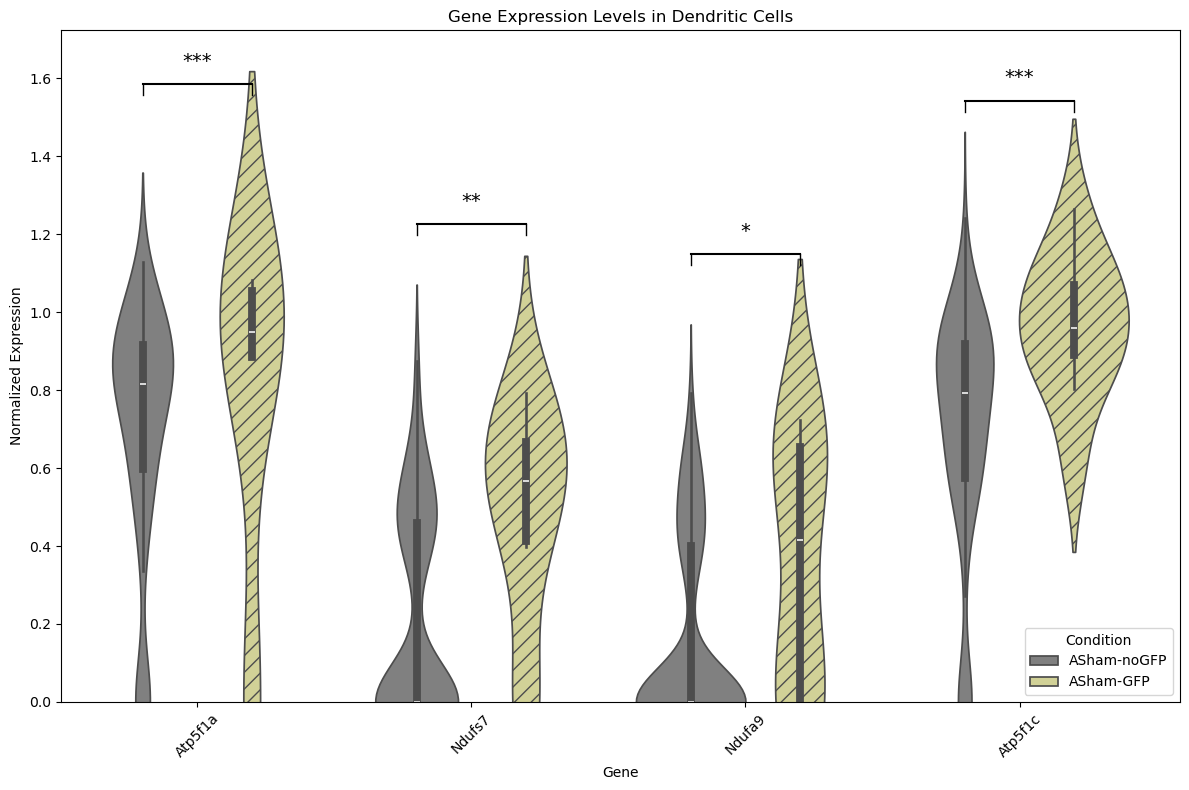

In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse
import numpy as np

# List of genes of interest
genes_of_interest = ['Atp5f1a', 'Ndufs7', 'Ndufa9', 'Atp5f1c']

# Filter to include only genes present in the dataset
available_genes = [gene for gene in genes_of_interest if gene in cell_subset.raw.var_names]
print(f"Available genes in the dataset: {available_genes}")

# Raise error if none are found
if not available_genes:
    raise ValueError("None of the genes of interest are present in the dataset.")

# Extract expression matrix from .raw
expr_matrix = cell_subset.raw.X.toarray() if scipy.sparse.issparse(cell_subset.raw.X) else cell_subset.raw.X

# Perform log-normalization (log1p) on the expression matrix
normalized_expr_matrix = np.log1p(expr_matrix)

# Create a DataFrame for plotting
data = []
for gene in available_genes:
    gene_index = cell_subset.raw.var_names.get_loc(gene)
    gene_expr = normalized_expr_matrix[:, gene_index]  # Use the normalized expression
    data.append(pd.DataFrame({
        'Condition': cell_subset.obs['condition'].values,
        'Gene': gene,
        'Expression': gene_expr
    }))

plot_data = pd.concat(data, ignore_index=True)

# Debugging
print(plot_data.head())
print(f"Number of rows in plot_data: {len(plot_data)}")

# Raise error if DataFrame is empty
if plot_data.empty:
    raise ValueError("The plot_data DataFrame is empty. Check the gene extraction and subsetting steps.")

# Sort results from stat_res by the 'stat' column in descending order
de = stat_res.results_df
de = de.sort_values('stat', ascending=False)

# Set color palette for the conditions
palette = {'ASham-noGFP': 'gray', 'ASham-GFP': '#dbdb8d'}

# Plot violin plot
plt.figure(figsize=(12, 8))
ax = sns.violinplot(
    x='Gene',
    y='Expression',
    hue='Condition',
    data=plot_data,
    palette=palette,
    inner='box',
    hue_order=['ASham-noGFP', 'ASham-GFP']
)

# Apply hatch pattern only to ASham-GFP violins
for i, artist in enumerate(ax.collections):
    if i % 2 == 1:  # ASham-GFP (2nd hue in each gene group)
        artist.set_hatch('//')

# Annotate statistical significance
max_expr = plot_data['Expression'].max()
line_spacing = max_expr * 0.15  # Increase line spacing (was 0.1)

tick_height = max_expr * 0.02
text_offset = max_expr * 0.025

# Add annotations with p-values for each gene
for i, gene in enumerate(available_genes):
    # Get p-value from stat_res.summary() for the gene
    if gene in de.index:
        padj = de.loc[gene, 'padj']
    else:
        padj = 1.0  # Default to no significance if the gene is not found
    
    # Handle NaN values in padj
    if pd.isna(padj):
        padj = 1.0  # If padj is NaN, consider it not significant
    
    # Assign significance symbol based on p-value thresholds
    symbol = '***' if padj < 0.001 else '**' if padj < 0.01 else '*' if padj < 0.05 else 'ns'
    
    # Position the annotation just above the maximum expression
    y = plot_data[plot_data['Gene'] == gene]['Expression'].max() + line_spacing

    # Ensure that the annotation stays within the plot limits
    if y > max_expr * 1.2:  # Prevent annotation from going too high
        y = max_expr * 1.2

    x1, x2 = i - 0.2, i + 0.2  # X-axis positions for the comparison
    ax.plot([x1, x2], [y, y], color='black', linewidth=1.5)  # Line for significance
    ax.plot([x1, x1], [y, y - tick_height], color='black', linewidth=1)  # Left tick
    ax.plot([x2, x2], [y, y - tick_height], color='black', linewidth=1)  # Right tick
    ax.text((x1 + x2) / 2, y + text_offset, symbol, ha='center', va='bottom', fontsize=14)

# Axis settings
plt.ylim(0, plot_data['Expression'].max() * 1.25)  # Adjust ylim to accommodate annotations
plt.title('Gene Expression Levels in Dendritic Cells')
plt.ylabel('Normalized Expression')  # Label y-axis as normalized expression
plt.xticks(rotation=45)

# Order legend
handles, labels = plt.gca().get_legend_handles_labels()
order = ['ASham-noGFP', 'ASham-GFP']
ordered_handles = [handles[labels.index(cond)] for cond in order]
plt.legend(ordered_handles, order, title='Condition')

# Save and display plot
plt.tight_layout()
plt.savefig('Violin_ASham1.png')
plt.show()


Available genes in the dataset: ['Atp5f1a', 'Ndufs7', 'Ndufa9', 'Atp5f1c']
     Condition     Gene  Expression
0    YSham-GFP  Atp5f1a    1.022750
1  YSham-noGFP  Atp5f1a    0.799384
2  YSham-noGFP  Atp5f1a    0.000000
3  YSham-noGFP  Atp5f1a    0.605336
4  YSham-noGFP  Atp5f1a    0.674504
Number of rows in plot_data: 4236


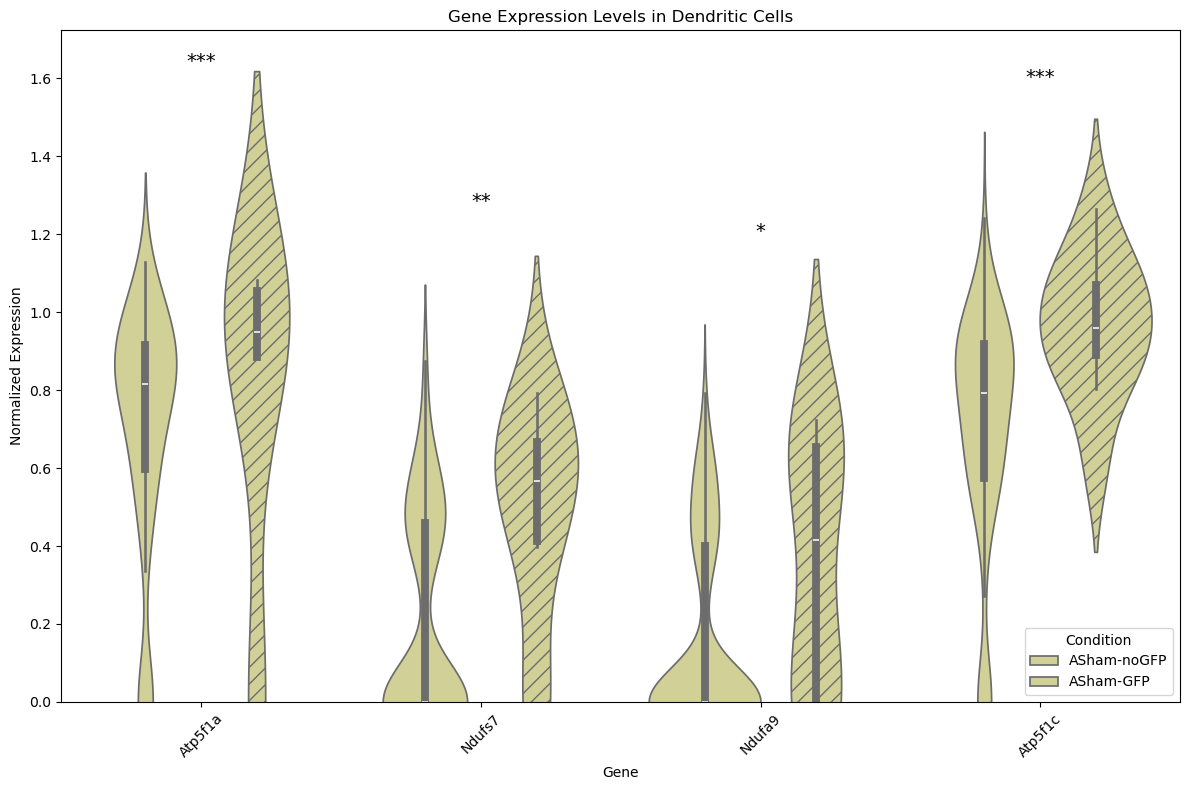

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse
import numpy as np

# List of genes of interest
genes_of_interest = ['Atp5f1a', 'Ndufs7', 'Ndufa9', 'Atp5f1c']

# Filter to include only genes present in the dataset
available_genes = [gene for gene in genes_of_interest if gene in cell_subset.raw.var_names]
print(f"Available genes in the dataset: {available_genes}")

# Raise error if none are found
if not available_genes:
    raise ValueError("None of the genes of interest are present in the dataset.")

# Extract expression matrix from .raw
expr_matrix = cell_subset.raw.X.toarray() if scipy.sparse.issparse(cell_subset.raw.X) else cell_subset.raw.X

# Perform log-normalization (log1p) on the expression matrix
normalized_expr_matrix = np.log1p(expr_matrix)

# Create a DataFrame for plotting
data = []
for gene in available_genes:
    gene_index = cell_subset.raw.var_names.get_loc(gene)
    gene_expr = normalized_expr_matrix[:, gene_index]  # Use the normalized expression
    data.append(pd.DataFrame({
        'Condition': cell_subset.obs['condition'].values,
        'Gene': gene,
        'Expression': gene_expr
    }))

plot_data = pd.concat(data, ignore_index=True)

# Debugging
print(plot_data.head())
print(f"Number of rows in plot_data: {len(plot_data)}")

# Raise error if DataFrame is empty
if plot_data.empty:
    raise ValueError("The plot_data DataFrame is empty. Check the gene extraction and subsetting steps.")

# Sort results from stat_res by the 'stat' column in descending order
de = stat_res.results_df
de = de.sort_values('stat', ascending=False)

# Set color palette for the conditions
palette = {'ASham-noGFP': '#dbdb8d', 'ASham-GFP': '#dbdb8d'}

# Plot violin plot
plt.figure(figsize=(12, 8))
ax = sns.violinplot(
    x='Gene',
    y='Expression',
    hue='Condition',
    data=plot_data,
    palette=palette,
    inner='box',
    hue_order=['ASham-noGFP', 'ASham-GFP']
)

# Apply hatch pattern only to ASham-GFP violins
for i, artist in enumerate(ax.collections):
    if i % 2 == 1:  # ASham-GFP (2nd hue in each gene group)
        artist.set_hatch('//')

# Annotate statistical significance (without the line)
max_expr = plot_data['Expression'].max()
line_spacing = max_expr * 0.15  # Increase line spacing (was 0.1)

text_offset = max_expr * 0.025

# Add annotations with p-values for each gene
for i, gene in enumerate(available_genes):
    # Get p-value from stat_res.summary() for the gene
    if gene in de.index:
        padj = de.loc[gene, 'padj']
    else:
        padj = 1.0  # Default to no significance if the gene is not found
    
    # Handle NaN values in padj
    if pd.isna(padj):
        padj = 1.0  # If padj is NaN, consider it not significant
    
    # Assign significance symbol based on p-value thresholds
    symbol = '***' if padj < 0.001 else '**' if padj < 0.01 else '*' if padj < 0.05 else 'ns'
    
    # Position the annotation just above the maximum expression
    y = plot_data[plot_data['Gene'] == gene]['Expression'].max() + line_spacing

    # Ensure that the annotation stays within the plot limits
    if y > max_expr * 1.2:  # Prevent annotation from going too high
        y = max_expr * 1.2

    x = i  # X-axis position for the comparison
    ax.text(x, y + text_offset, symbol, ha='center', va='bottom', fontsize=14)

# Axis settings
plt.ylim(0, plot_data['Expression'].max() * 1.25)  # Adjust ylim to accommodate annotations
plt.title('Gene Expression Levels in Dendritic Cells')
plt.ylabel('Normalized Expression')  # Label y-axis as normalized expression
plt.xticks(rotation=45)

# Order legend
handles, labels = plt.gca().get_legend_handles_labels()
order = ['ASham-noGFP', 'ASham-GFP']
ordered_handles = [handles[labels.index(cond)] for cond in order]
plt.legend(ordered_handles, order, title='Condition')

# Save and display plot
plt.tight_layout()
plt.savefig('Violin_ASham1.png')
plt.show()


Available genes in the dataset: ['Nfkb1', 'Malt1', 'Rftn1', 'Fyn']
     Condition   Gene  Expression
0    YSham-GFP  Nfkb1    1.209856
1  YSham-noGFP  Nfkb1    0.000000
2  YSham-noGFP  Nfkb1    0.952656
3  YSham-noGFP  Nfkb1    1.291254
4  YSham-noGFP  Nfkb1    1.018123
Number of rows in plot_data: 4236


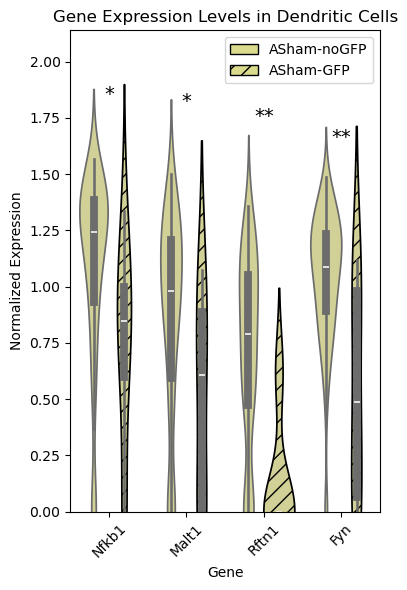

In [103]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse
import numpy as np
from matplotlib.patches import Patch

sc.settings.figdir = "FIGURE_3"
# List of genes of interest
genes_of_interest = ['Nfkb1', 'Malt1', 'Rftn1', 'Fyn']

# Filter to include only genes present in the dataset
available_genes = [gene for gene in genes_of_interest if gene in cell_subset.raw.var_names]
print(f"Available genes in the dataset: {available_genes}")

# Raise error if none are found
if not available_genes:
    raise ValueError("None of the genes of interest are present in the dataset.")

# Extract expression matrix from .raw
expr_matrix = cell_subset.raw.X.toarray() if scipy.sparse.issparse(cell_subset.raw.X) else cell_subset.raw.X

# Perform log-normalization (log1p) on the expression matrix
normalized_expr_matrix = np.log1p(expr_matrix)

# Create a DataFrame for plotting
data = []
for gene in available_genes:
    gene_index = cell_subset.raw.var_names.get_loc(gene)
    gene_expr = normalized_expr_matrix[:, gene_index]  # Use the normalized expression
    data.append(pd.DataFrame({
        'Condition': cell_subset.obs['condition'].values,
        'Gene': gene,
        'Expression': gene_expr
    }))

plot_data = pd.concat(data, ignore_index=True)

# Debugging
print(plot_data.head())
print(f"Number of rows in plot_data: {len(plot_data)}")

# Raise error if DataFrame is empty
if plot_data.empty:
    raise ValueError("The plot_data DataFrame is empty. Check the gene extraction and subsetting steps.")

# Sort results from stat_res by the 'stat' column in descending order
de = stat_res.results_df
de = de.sort_values('stat', ascending=False)

# Set color palette for the conditions
palette = {'ASham-noGFP': '#dbdb8d', 'ASham-GFP': '#dbdb8d'}

# Plot violin plot
plt.figure(figsize=(4, 6))
ax = sns.violinplot(
    x='Gene',
    y='Expression',
    hue='Condition',
    data=plot_data,
    palette=palette,
    inner='box',
    hue_order=['ASham-noGFP', 'ASham-GFP']
)

# Apply hatch pattern only to ASham-GFP violins
for i, artist in enumerate(ax.collections):
    if i % 2 == 1:  # ASham-GFP (2nd hue in each gene group)
        artist.set_hatch('//')
        artist.set_edgecolor('black')  # optional: make hatch clearer

# Annotate statistical significance
max_expr = plot_data['Expression'].max()
line_spacing = max_expr * 0.15
text_offset = max_expr * 0.025

for i, gene in enumerate(available_genes):
    gene_data = plot_data[plot_data['Gene'] == gene]
    
    # Padj from your DE results
    padj = de.loc[gene, 'padj'] if gene in de.index else 1.0
    padj = 1.0 if pd.isna(padj) else padj
    
    # Significance symbol
    symbol = '***' if padj < 0.001 else '**' if padj < 0.01 else '*' if padj < 0.05 else 'ns'
    
    # Get maximum box height per gene (from both conditions)
    max_expr_per_gene = gene_data.groupby('Condition')['Expression'].max().max()

    # Small offset above the top box/violin for placing the text
    y = max_expr_per_gene + 0.1  # Adjust as needed
    x = i  # center of the gene group

    ax.text(x, y, symbol, ha='center', va='bottom', fontsize=14)


# Axis settings
plt.ylim(0, plot_data['Expression'].max() * 1.25)
plt.title('Gene Expression Levels in Dendritic Cells')
plt.ylabel('Normalized Expression')
plt.xticks(rotation=45)

# Custom legend with hatch pattern
legend_elements = [
    Patch(facecolor='#dbdb8d', edgecolor='black', label='ASham-noGFP'),
    Patch(facecolor='#dbdb8d', edgecolor='black', hatch='//', label='ASham-GFP')
]
plt.legend(handles=legend_elements)

# Save and show plot
plt.tight_layout()
plt.savefig('Violin_ASham1_reduced.png')
plt.show()


Available genes in the dataset: ['Atp5f1a', 'Ndufs7', 'Ndufa9', 'Atp5f1c']
     Condition     Gene  Expression
0    YSham-GFP  Atp5f1a    1.780832
1  YSham-noGFP  Atp5f1a    1.224171
2  YSham-noGFP  Atp5f1a    0.000000
3  YSham-noGFP  Atp5f1a    0.831868
4  YSham-noGFP  Atp5f1a    0.963058
Number of rows in plot_data: 4236


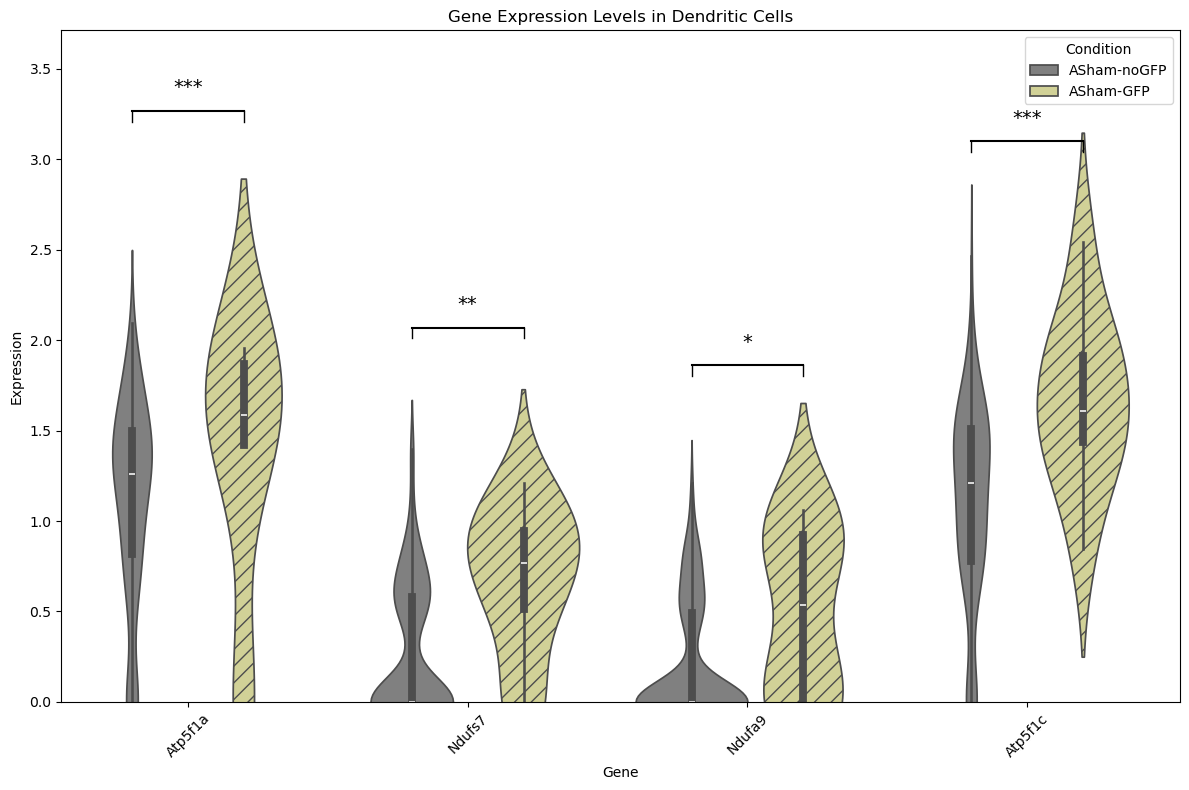

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse

# List of genes of interest
genes_of_interest = ['Atp5f1a', 'Ndufs7', 'Ndufa9', 'Atp5f1c']

# Filter to include only genes present in the dataset
available_genes = [gene for gene in genes_of_interest if gene in cell_subset.raw.var_names]
print(f"Available genes in the dataset: {available_genes}")

# Raise error if none are found
if not available_genes:
    raise ValueError("None of the genes of interest are present in the dataset.")

# Extract expression matrix from .raw
expr_matrix = cell_subset.raw.X.toarray() if scipy.sparse.issparse(cell_subset.raw.X) else cell_subset.raw.X

# Create a DataFrame for plotting
data = []
for gene in available_genes:
    gene_index = cell_subset.raw.var_names.get_loc(gene)
    gene_expr = expr_matrix[:, gene_index]
    data.append(pd.DataFrame({
        'Condition': cell_subset.obs['condition'].values,
        'Gene': gene,
        'Expression': gene_expr
    }))

plot_data = pd.concat(data, ignore_index=True)

# Debugging
print(plot_data.head())
print(f"Number of rows in plot_data: {len(plot_data)}")

# Raise error if DataFrame is empty
if plot_data.empty:
    raise ValueError("The plot_data DataFrame is empty. Check the gene extraction and subsetting steps.")

# Sort results from stat_res by the 'stat' column in descending order
de = stat_res.results_df
de = de.sort_values('stat', ascending=False)

# Set color palette for the conditions
palette = {'ASham-noGFP': 'gray', 'ASham-GFP': '#dbdb8d'}

# Plot violin plot
plt.figure(figsize=(12, 8))
ax = sns.violinplot(
    x='Gene',
    y='Expression',
    hue='Condition',
    data=plot_data,
    palette=palette,
    inner='box',
    hue_order=['ASham-noGFP', 'ASham-GFP']
)

# Apply hatch pattern only to ASham-GFP violins
for i, artist in enumerate(ax.collections):
    if i % 2 == 1:  # ASham-GFP (2nd hue in each gene group)
        artist.set_hatch('//')

# Annotate statistical significance
max_expr = plot_data['Expression'].max()
line_spacing = max_expr * 0.1  # Increase the line spacing to ensure it's above the bar
tick_height = max_expr * 0.02
text_offset = max_expr * 0.025

# Add annotations with p-values for each gene
for i, gene in enumerate(available_genes):
    # Get p-value from stat_res.summary() for the gene
    if gene in de.index:
        padj = de.loc[gene, 'padj']
    else:
        padj = 1.0  # Default to no significance if the gene is not found
    
    # Handle NaN values in padj
    if pd.isna(padj):
        padj = 1.0  # If padj is NaN, consider it not significant
    
    # Assign significance symbol based on p-value thresholds
    symbol = '***' if padj < 0.001 else '**' if padj < 0.01 else '*' if padj < 0.05 else 'ns'
    
    # Position the annotation just above the maximum expression
    y = plot_data[plot_data['Gene'] == gene]['Expression'].max() + line_spacing

    # Ensure that the annotation stays within the plot limits
    if y > max_expr * 1.2:  # Prevent annotation from going too high
        y = max_expr * 1.2

    x1, x2 = i - 0.2, i + 0.2  # X-axis positions for the comparison
    ax.plot([x1, x2], [y, y], color='black', linewidth=1.5)  # Line for significance
    ax.plot([x1, x1], [y, y - tick_height], color='black', linewidth=1)  # Left tick
    ax.plot([x2, x2], [y, y - tick_height], color='black', linewidth=1)  # Right tick
    ax.text((x1 + x2) / 2, y + text_offset, symbol, ha='center', va='bottom', fontsize=14)

# Axis settings
plt.ylim(0, plot_data['Expression'].max() * 1.25)  # Adjust ylim to accommodate annotations
plt.title('Gene Expression Levels in Dendritic Cells')
plt.xticks(rotation=45)

# Order legend
handles, labels = plt.gca().get_legend_handles_labels()
order = ['ASham-noGFP', 'ASham-GFP']
ordered_handles = [handles[labels.index(cond)] for cond in order]
plt.legend(ordered_handles, order, title='Condition')

# Save and display plot
plt.tight_layout()
plt.savefig('Violin_ASham1.png')
plt.show()


Available genes in the dataset: ['Atp5f1a', 'Ndufs7', 'Ndufa9', 'Atp5f1c']
     Condition     Gene  Expression
0    YSham-GFP  Atp5f1a    1.022750
1  YSham-noGFP  Atp5f1a    0.799384
2  YSham-noGFP  Atp5f1a    0.000000
3  YSham-noGFP  Atp5f1a    0.605336
4  YSham-noGFP  Atp5f1a    0.674504
Number of rows in plot_data: 4236


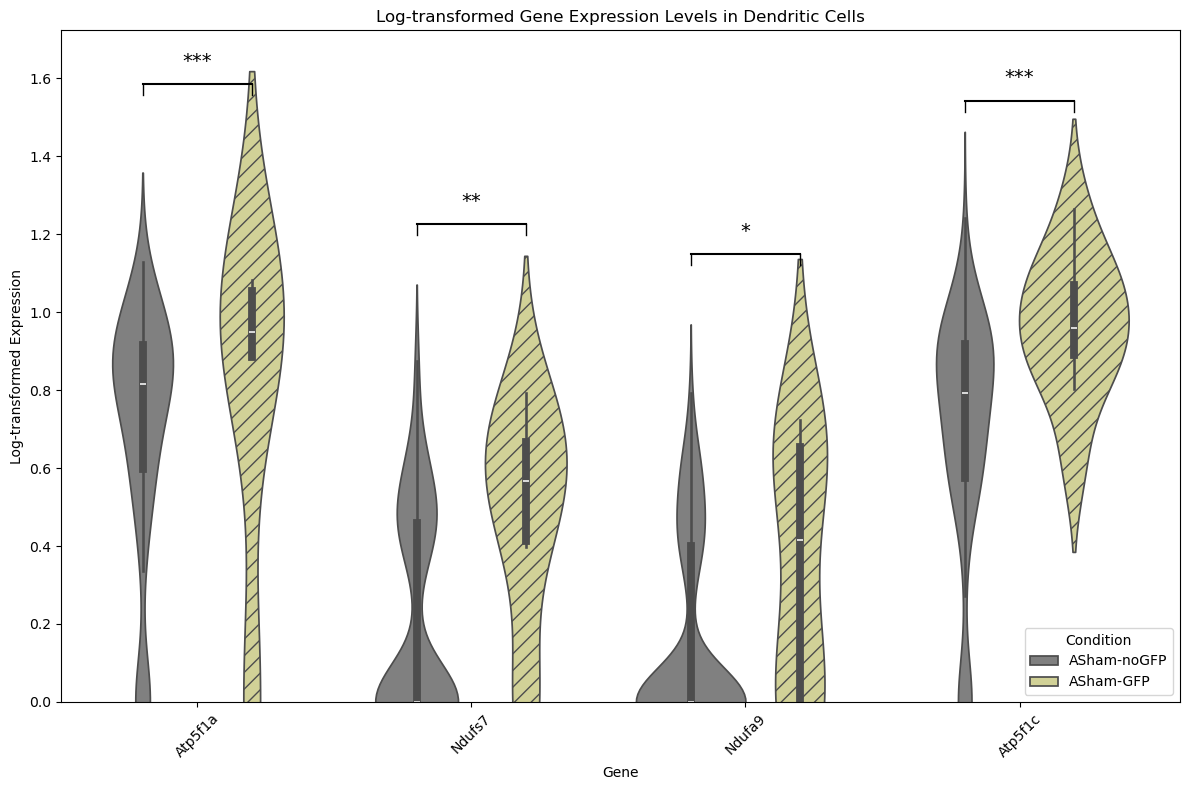

In [42]:
import numpy as np

# List of genes of interest
genes_of_interest = ['Atp5f1a', 'Ndufs7', 'Ndufa9', 'Atp5f1c']

# Filter to include only genes present in the dataset
available_genes = [gene for gene in genes_of_interest if gene in cell_subset.raw.var_names]
print(f"Available genes in the dataset: {available_genes}")

# Raise error if none are found
if not available_genes:
    raise ValueError("None of the genes of interest are present in the dataset.")

# Extract expression matrix from .raw
expr_matrix = cell_subset.raw.X.toarray() if scipy.sparse.issparse(cell_subset.raw.X) else cell_subset.raw.X

# Log transform the expression values (log(1 + expression) to handle zeros)
log_expr_matrix = np.log1p(expr_matrix)  # This applies log(1 + expression)

# Create a DataFrame for plotting
data = []
for gene in available_genes:
    gene_index = cell_subset.raw.var_names.get_loc(gene)
    gene_expr = log_expr_matrix[:, gene_index]  # Log-transformed expression values
    data.append(pd.DataFrame({
        'Condition': cell_subset.obs['condition'].values,
        'Gene': gene,
        'Expression': gene_expr
    }))

plot_data = pd.concat(data, ignore_index=True)

# Debugging
print(plot_data.head())
print(f"Number of rows in plot_data: {len(plot_data)}")

# Raise error if DataFrame is empty
if plot_data.empty:
    raise ValueError("The plot_data DataFrame is empty. Check the gene extraction and subsetting steps.")

# Sort results from stat_res by the 'stat' column in descending order
de = stat_res.results_df
de = de.sort_values('stat', ascending=False)

# Set color palette for the conditions
palette = {'ASham-noGFP': 'gray', 'ASham-GFP': '#dbdb8d'}

# Plot violin plot with log-transformed expression data
plt.figure(figsize=(12, 8))
ax = sns.violinplot(
    x='Gene',
    y='Expression',
    hue='Condition',
    data=plot_data,
    palette=palette,
    inner='box',
    hue_order=['ASham-noGFP', 'ASham-GFP']
)

# Apply hatch pattern only to ASham-GFP violins
for i, artist in enumerate(ax.collections):
    if i % 2 == 1:  # ASham-GFP (2nd hue in each gene group)
        artist.set_hatch('//')

# Annotate statistical significance
max_expr = plot_data['Expression'].max()
line_spacing = max_expr * 0.15  # Increase line spacing to ensure the line is above the bar
tick_height = max_expr * 0.02
text_offset = max_expr * 0.025

# Add annotations with p-values for each gene
for i, gene in enumerate(available_genes):
    # Get p-value from stat_res.summary() for the gene
    if gene in de.index:
        padj = de.loc[gene, 'padj']
    else:
        padj = 1.0  # Default to no significance if the gene is not found
    
    # Handle NaN values in padj
    if pd.isna(padj):
        padj = 1.0  # If padj is NaN, consider it not significant
    
    # Assign significance symbol based on p-value thresholds
    symbol = '***' if padj < 0.001 else '**' if padj < 0.01 else '*' if padj < 0.05 else 'ns'
    
    # Position the annotation just above the maximum expression
    y = plot_data[plot_data['Gene'] == gene]['Expression'].max() + line_spacing

    # Ensure that the annotation stays within the plot limits
    if y > max_expr * 1.2:  # Prevent annotation from going too high
        y = max_expr * 1.2

    x1, x2 = i - 0.2, i + 0.2  # X-axis positions for the comparison
    ax.plot([x1, x2], [y, y], color='black', linewidth=1.5)  # Line for significance
    ax.plot([x1, x1], [y, y - tick_height], color='black', linewidth=1)  # Left tick
    ax.plot([x2, x2], [y, y - tick_height], color='black', linewidth=1)  # Right tick
    ax.text((x1 + x2) / 2, y + text_offset, symbol, ha='center', va='bottom', fontsize=14)

# Axis settings
plt.ylim(0, plot_data['Expression'].max() * 1.25)  # Adjust ylim to accommodate annotations
plt.title('Log-transformed Gene Expression Levels in Dendritic Cells')
plt.ylabel('Log-transformed Expression')
plt.xticks(rotation=45)

# Order legend
handles, labels = plt.gca().get_legend_handles_labels()
order = ['ASham-noGFP', 'ASham-GFP']
ordered_handles = [handles[labels.index(cond)] for cond in order]
plt.legend(ordered_handles, order, title='Condition')

# Save and display plot
plt.tight_layout()
plt.savefig('Violin_ASham1_log_expression.png')
plt.show()


Available genes in the dataset: ['Atp5f1a', 'Atp5f1b', 'Ndufs8', 'Cox4i1']
     Condition     Gene  Expression
0    YSham-GFP  Atp5f1a    1.780832
1  YSham-noGFP  Atp5f1a    1.224171
2  YSham-noGFP  Atp5f1a    0.000000
3  YSham-noGFP  Atp5f1a    0.831868
4  YSham-noGFP  Atp5f1a    0.963058
Number of rows in plot_data: 4236


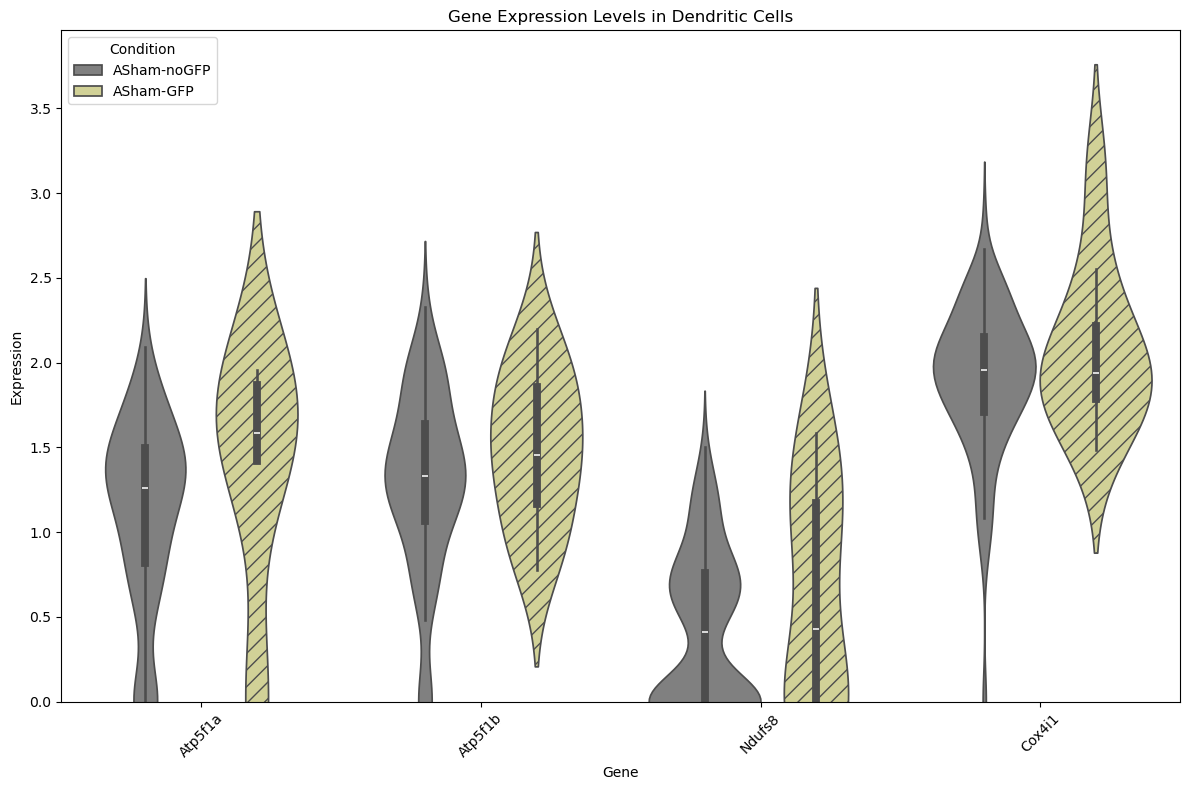

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.sparse import csr_matrix

# Subset for dendritic cells (update comment for accuracy)
cell_subset = adata[adata.obs['cell type'] == "Dendritic cells"].copy()

# Convert X to sparse matrix if needed
cell_subset.X = csr_matrix(cell_subset.X)

# Define color palette
palette = {'ASham-noGFP': 'gray', 'ASham-GFP': '#dbdb8d'}

# List of genes of interest
genes_of_interest = ['Atp5f1a', 'Atp5f1b', 'Ndufs8', 'Cox4i1']

# Filter to include only genes present in the dataset
available_genes = [gene for gene in genes_of_interest if gene in cell_subset.raw.var_names]
print(f"Available genes in the dataset: {available_genes}")

# Raise error if none are found
if not available_genes:
    raise ValueError("None of the genes of interest are present in the dataset.")

# Extract expression matrix from .raw
expr_matrix = cell_subset.raw.X.toarray() if scipy.sparse.issparse(cell_subset.raw.X) else cell_subset.raw.X

# Create a DataFrame for plotting
data = []
for gene in available_genes:
    gene_index = cell_subset.raw.var_names.get_loc(gene)
    gene_expr = expr_matrix[:, gene_index]
    data.append(pd.DataFrame({
        'Condition': cell_subset.obs['condition'].values,
        'Gene': gene,
        'Expression': gene_expr
    }))

plot_data = pd.concat(data, ignore_index=True)

# Debugging
print(plot_data.head())
print(f"Number of rows in plot_data: {len(plot_data)}")

# Raise error if DataFrame is empty
if plot_data.empty:
    raise ValueError("The plot_data DataFrame is empty. Check the gene extraction and subsetting steps.")

# Plot violin plot
plt.figure(figsize=(12, 8))
ax = sns.violinplot(
    x='Gene',
    y='Expression',
    hue='Condition',
    data=plot_data,
    palette=palette,
    inner='box',
    hue_order=['ASham-noGFP', 'ASham-GFP']
)

# Apply hatch pattern only to ASham-GFP violins
for i, artist in enumerate(ax.collections):
    if i % 2 == 1:  # ASham-GFP (2nd hue in each gene group)
        artist.set_hatch('//')

# Axis settings
plt.ylim(0, plot_data['Expression'].max() * 1.1)
plt.title('Gene Expression Levels in Dendritic Cells')
plt.xticks(rotation=45)

# Order legend
handles, labels = plt.gca().get_legend_handles_labels()
order = ['ASham-noGFP', 'ASham-GFP']
ordered_handles = [handles[labels.index(cond)] for cond in order]
plt.legend(ordered_handles, order, title='Condition')

# Save and display plot
plt.tight_layout()
plt.savefig('Violin_ASham1.png')
plt.show()


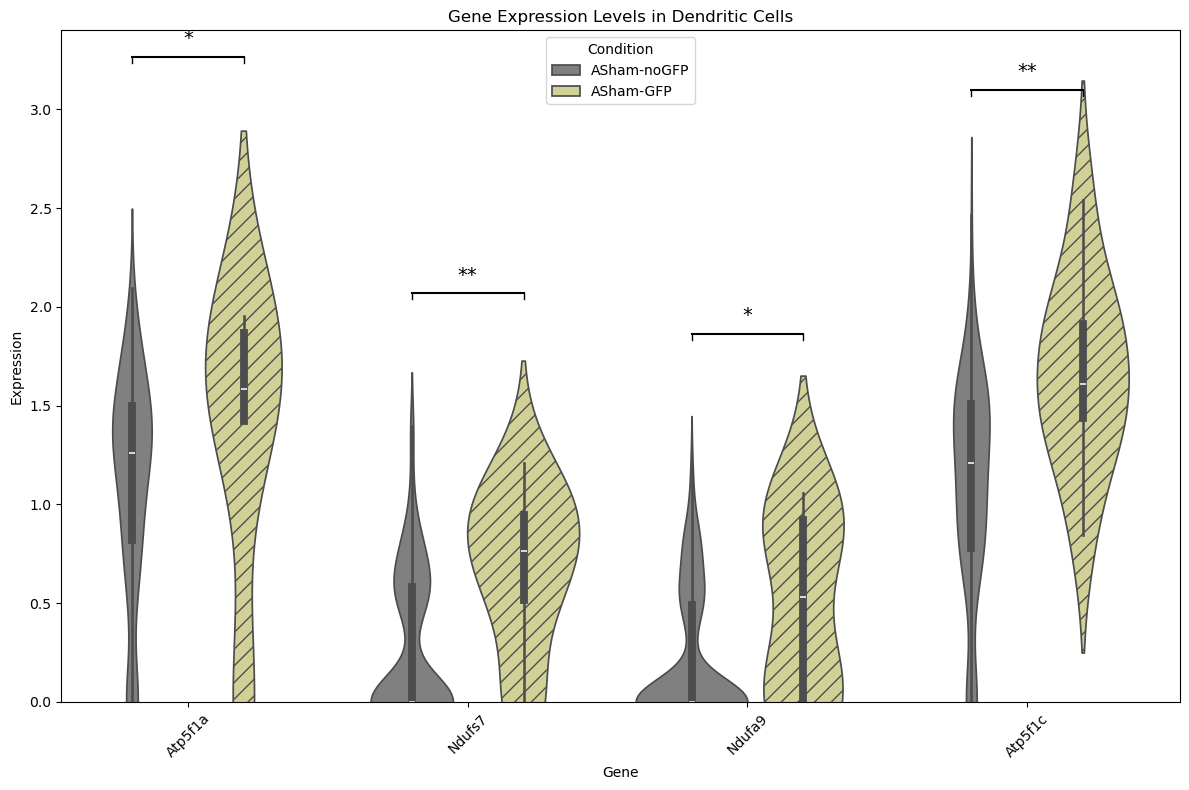

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.sparse import csr_matrix
from scipy.stats import mannwhitneyu

# Subset for dendritic cells
cell_subset = adata[adata.obs['cell type'] == "Dendritic cells"].copy()

# Convert to sparse matrix
cell_subset.X = csr_matrix(cell_subset.X)

# Define color palette
palette = {'ASham-noGFP': 'gray', 'ASham-GFP': '#dbdb8d'}

# Genes of interest
genes_of_interest = ['Atp5f1a', 'Ndufs7', 'Ndufa9', 'Atp5f1c']
available_genes = [gene for gene in genes_of_interest if gene in cell_subset.raw.var_names]

if not available_genes:
    raise ValueError("None of the genes of interest are present in the dataset.")

# Convert to dense if sparse
expr_matrix = cell_subset.raw.X.toarray() if scipy.sparse.issparse(cell_subset.raw.X) else cell_subset.raw.X

# Create plotting data
data = []
for gene in available_genes:
    gene_index = cell_subset.raw.var_names.get_loc(gene)
    gene_expr = expr_matrix[:, gene_index]
    data.append(pd.DataFrame({
        'Condition': cell_subset.obs['condition'].values,
        'Gene': gene,
        'Expression': gene_expr
    }))
plot_data = pd.concat(data, ignore_index=True)

# Plot
plt.figure(figsize=(12, 8))
ax = sns.violinplot(
    x='Gene',
    y='Expression',
    hue='Condition',
    data=plot_data,
    palette=palette,
    inner='box',
    hue_order=['ASham-noGFP', 'ASham-GFP']
)

# Apply hatch to ASham-GFP violins
for i, artist in enumerate(ax.collections):
    if i % 2 == 1:
        artist.set_hatch('//')

# Statistical testing and annotation
max_expr = plot_data['Expression'].max()
line_spacing = max_expr * 0.1  # vertical space between violin and significance line
tick_height = max_expr * 0.01
text_offset = max_expr * 0.015

for i, gene in enumerate(available_genes):
    gene_data = plot_data[plot_data['Gene'] == gene]
    group1 = gene_data[gene_data['Condition'] == 'ASham-noGFP']['Expression']
    group2 = gene_data[gene_data['Condition'] == 'ASham-GFP']['Expression']
    stat, pval = mannwhitneyu(group1, group2, alternative='two-sided')

    # Decide annotation
    if pval < 0.001:
        symbol = '***'
    elif pval < 0.01:
        symbol = '**'
    elif pval < 0.05:
        symbol = '*'
    else:
        symbol = 'ns'

    # Determine line position
    y = gene_data['Expression'].max() + line_spacing
    x1, x2 = i - 0.2, i + 0.2

    # Horizontal line
    ax.plot([x1, x2], [y, y], color='black', linewidth=1.5)
    # Vertical ticks
    ax.plot([x1, x1], [y, y - tick_height], color='black', linewidth=1)
    ax.plot([x2, x2], [y, y - tick_height], color='black', linewidth=1)
    # Significance text
    ax.text((x1 + x2) / 2, y + text_offset, symbol, ha='center', va='bottom', fontsize=14)

# Tidy up
plt.ylim(0, max_expr + line_spacing + text_offset * 3)
plt.title('Gene Expression Levels in Dendritic Cells')
plt.xticks(rotation=45)

# Fix legend order
handles, labels = ax.get_legend_handles_labels()
order = ['ASham-noGFP', 'ASham-GFP']
ordered_handles = [handles[labels.index(cond)] for cond in order]
plt.legend(ordered_handles, order, title='Condition')

plt.tight_layout()
plt.savefig('Violin_ASham1_with_significance.png')
plt.show()


In [3]:
import pandas as pd
import numpy as np
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import random
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)



# -------------------- Subset dendritic cells --------------------

cell_subset = adata[adata.obs['cell type'] == 'Dendritic cells']
#example WITH pseudo replicates
pbs = []
for sample in cell_subset.obs.Sample.unique():
    samp_cell_subset = cell_subset[cell_subset.obs['Sample'] == sample]
    
    samp_cell_subset.X = samp_cell_subset.layers['counts'] #make sure to use raw data
    
    
    
    indices = list(samp_cell_subset.obs_names)
    random.shuffle(indices)
    indices = np.array_split(np.array(indices), 4) #change number here for number of replicates deisred
    
    for i, pseudo_rep in enumerate(indices):
    
        rep_adata = sc.AnnData(X = samp_cell_subset[indices[i]].X.sum(axis = 0),
                               var = samp_cell_subset[indices[i]].var[[]])

        rep_adata.obs_names = [sample + '_' + str(i)]
        rep_adata.obs['condition'] = samp_cell_subset.obs['condition'].iloc[0]
        rep_adata.obs['replicate'] = i

        pbs.append(rep_adata)
        
# Combine pseudo-replicates
pb = sc.concat(pbs)

# -------------------- Prepare for DESeq2 --------------------
counts = pd.DataFrame(pb.X, columns = pb.var_names) #need to do this to pass var names

# Create DeseqDataSet object with pseudo-replicates
dds = DeseqDataSet(
    counts=counts,  # Make sure 'counts' is correctly defined
    metadata=pb.obs,
    design_factors=['condition', 'replicate']  # Adjust to 'pseudo_replicate_group' if needed
)
sc.pp.filter_genes(dds, min_cells = 1)

dds.deseq2()

stat_res = DeseqStats(dds, contrast=('condition', 'ASham-GFP', 'ASham-noGFP'))
stat_res.summary()
results_df = stat_res.results_df



Fitting size factors...
Fitting dispersions...
... done in 1.64 seconds.

Fitting MAP dispersions...
... done in 2.58 seconds.

Fitting dispersions...
... done in 2.15 seconds.

Fitting MAP dispersions...
... done in 2.64 seconds.

Fitting dispersions...
... done in 1.67 seconds.

Fitting MAP dispersions...
... done in 3.06 seconds.

Fitting dispersions...
... done in 1.22 seconds.

Fitting MAP dispersions...
... done in 2.75 seconds.

Fitting dispersions...
... done in 1.17 seconds.

Fitting MAP dispersions...
... done in 3.07 seconds.

Fitting dispersions...
... done in 1.09 seconds.

Fitting MAP dispersions...
... done in 3.02 seconds.

Fitting dispersions...
... done in 1.14 seconds.

Fitting MAP dispersions...
... done in 2.93 seconds.

Fitting dispersions...
... done in 1.09 seconds.

Fitting MAP dispersions...
... done in 2.88 seconds.

Fitting dispersions...
... done in 1.18 seconds.

Fitting MAP dispersions...
... done in 2.70 seconds.

Fitting dispersions...
... done in 1.24 

Log2 fold change & Wald test p-value: condition ASham-GFP vs ASham-noGFP
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Pcmtd1              1.920580        0.211206  0.928908  0.227370  0.820136   
Exo1                0.075068        3.269856  4.586530  0.712926  0.475892   
Uxs1                1.210269        1.239390  0.889704  1.393036  0.163609   
Cdh19               0.004039        4.992407  6.303053  0.792062  0.428325   
Dsel                0.074636        3.117631  2.801558  1.112821  0.265785   
...                      ...             ...       ...       ...       ...   
ENSMUSG00000144196  0.671945        0.475309  1.374710  0.345752  0.729529   
ENSMUSG00000079808  0.018320        5.700925  6.406998  0.889797  0.373575   
ENSMUSG00000095041  0.755909       -0.094008  1.485883 -0.063267  0.949554   
ENSMUSG00000144201  0.240208        2.522798  2.173827  1.160533  0.245832   
Gfp                 0.001795        5.713748  6.392402  0.893834  0.3

... done in 0.96 seconds.



In [13]:
counts = pd.DataFrame(pb.X, columns = pb.var_names, index=pb.obs_names)


# Create DeseqDataSet object with pseudo-replicates
dds = DeseqDataSet(
    counts=counts,  # Make sure 'counts' is correctly defined
    metadata=pb.obs,
    design_factors=['condition', 'replicate']  # Adjust to 'pseudo_replicate_group' if needed
)
sc.pp.filter_genes(dds, min_cells = 1)

dds.deseq2()

stat_res = DeseqStats(dds, contrast=('condition', 'ASham-GFP', 'ASham-noGFP'))
stat_res.summary()
results_df = stat_res.results_df



Fitting size factors...
Fitting dispersions...
... done in 1.58 seconds.

Fitting MAP dispersions...
... done in 2.40 seconds.

Fitting dispersions...
... done in 1.99 seconds.

Fitting MAP dispersions...
... done in 2.44 seconds.

Fitting dispersions...
... done in 1.87 seconds.

Fitting MAP dispersions...
... done in 2.91 seconds.

Fitting dispersions...
... done in 1.25 seconds.

Fitting MAP dispersions...
... done in 2.87 seconds.

Fitting dispersions...
... done in 1.10 seconds.

Fitting MAP dispersions...
... done in 2.91 seconds.

Fitting dispersions...
... done in 1.10 seconds.

Fitting MAP dispersions...
... done in 3.11 seconds.

Fitting dispersions...
... done in 1.12 seconds.

Fitting MAP dispersions...
... done in 2.77 seconds.

Fitting dispersions...
... done in 1.18 seconds.

Fitting MAP dispersions...
... done in 3.03 seconds.

Fitting dispersions...
... done in 1.14 seconds.

Fitting MAP dispersions...
... done in 2.90 seconds.

Fitting dispersions...
... done in 1.14 

Log2 fold change & Wald test p-value: condition ASham-GFP vs ASham-noGFP
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Pcmtd1              1.920580        0.211206  0.928908  0.227370  0.820136   
Exo1                0.075068        3.269856  4.586530  0.712926  0.475892   
Uxs1                1.210269        1.239390  0.889704  1.393036  0.163609   
Cdh19               0.004039        4.992407  6.303053  0.792062  0.428325   
Dsel                0.074636        3.117631  2.801558  1.112821  0.265785   
...                      ...             ...       ...       ...       ...   
ENSMUSG00000144196  0.671945        0.475309  1.374710  0.345752  0.729529   
ENSMUSG00000079808  0.018320        5.700925  6.406998  0.889797  0.373575   
ENSMUSG00000095041  0.755909       -0.094008  1.485883 -0.063267  0.949554   
ENSMUSG00000144201  0.240208        2.522798  2.173827  1.160533  0.245832   
Gfp                 0.001795        5.713748  6.392402  0.893834  0.3

... done in 0.71 seconds.



Condition   AOV-GFP  AOV-noGFP  ASham-GFP  ASham-noGFP   YOV-GFP  YOV-noGFP  \
Gene                                                                          
Atp5f1a    3.669727   5.520168   2.476671     4.777792  3.357779   4.512219   
Atp5f1c    3.629157   5.499304   2.470183     4.710830  3.081031   4.789458   
Ndufa9     1.006338   3.534914   0.934417     2.717855  1.324579   2.662070   
Ndufs7     1.772519   3.772043   1.235411     3.047295  2.217947   3.301400   

Condition  YSham-GFP  YSham-noGFP  
Gene                               
Atp5f1a     0.677013     4.245278  
Atp5f1c     0.621227     4.531332  
Ndufa9      0.274653     2.561982  
Ndufs7      0.173287     3.385748  


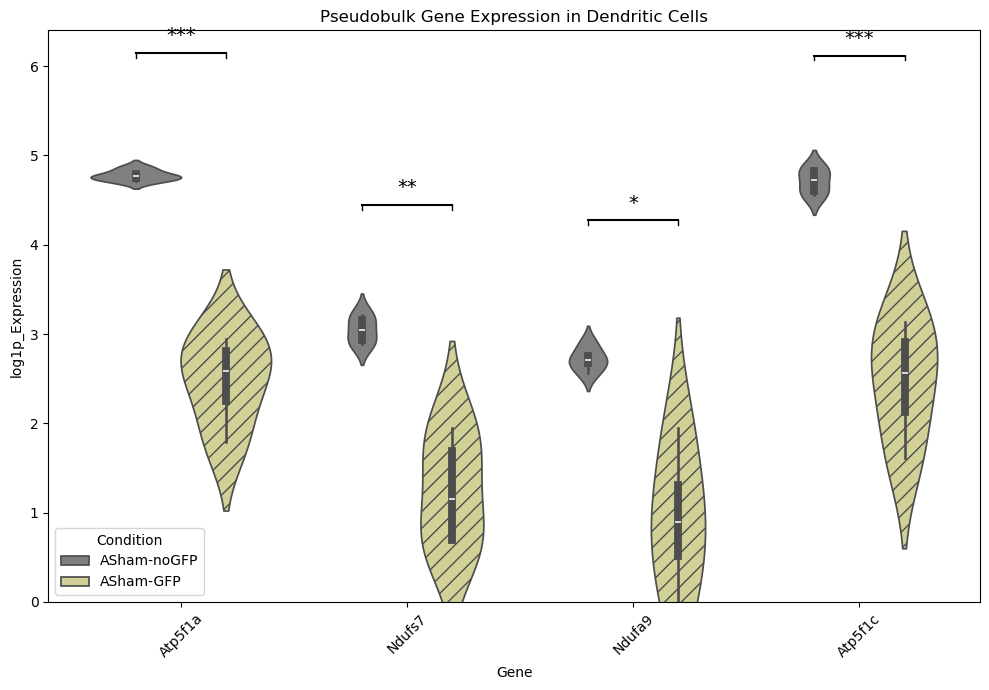

In [23]:
# -------------------- Plotting --------------------
palette = {'ASham-noGFP': 'gray', 'ASham-GFP': '#dbdb8d'}
genes_of_interest = ['Atp5f1a', 'Ndufs7', 'Ndufa9', 'Atp5f1c']
available_genes = [gene for gene in genes_of_interest if gene in counts.columns]

# Long format for plotting
plot_data = []
for gene in available_genes:
    for sample in pb.obs_names:
        if gene in counts.columns and sample in counts.index:
            expr = counts.loc[sample, gene]
            cond = pb.obs.loc[sample, 'condition']
            plot_data.append({
                "Gene": gene,
                "Expression": expr,
                "Condition": cond
            })

if not plot_data:
    raise ValueError("No matching gene expression data found in 'counts'.")

plot_data = pd.DataFrame(plot_data)

# Normalize expression
plot_data["log1p_Expression"] = np.log1p(plot_data["Expression"])

# Preview means
print(plot_data.groupby(["Gene", "Condition"])["log1p_Expression"].mean().unstack())

plt.figure(figsize=(10, 7))
ax = sns.violinplot(
    x="Gene", y="log1p_Expression", hue="Condition", data=plot_data,
    palette=palette, inner="box", hue_order=["ASham-noGFP", "ASham-GFP"]
)

# Hatching fix: handle by hue
# Identify collections corresponding to ASham-GFP
legend_labels = [t.get_text() for t in ax.legend_.get_texts()]
for i, artist in enumerate(ax.collections):
    # Violinplot groups hues: 2 violins per gene
    gene_index = i // 2
    is_gfp = (i % 2 == 1)  # ASham-GFP is second in hue_order
    if is_gfp:
        artist.set_hatch('//')

# Significance stars
max_expr = plot_data['log1p_Expression'].max()
line_spacing = max_expr * 0.1
tick_height = max_expr * 0.01
text_offset = max_expr * 0.015

for i, gene in enumerate(available_genes):
    pval = results_df.loc[gene, 'padj'] if gene in results_df.index else 1.0
    symbol = '***' if pval < 0.001 else '**' if pval < 0.01 else '*' if pval < 0.05 else 'ns'
    y = plot_data[plot_data['Gene'] == gene]['log1p_Expression'].max() + line_spacing
    x1, x2 = i - 0.2, i + 0.2
    ax.plot([x1, x2], [y, y], color='black', linewidth=1.5)
    ax.plot([x1, x1], [y, y - tick_height], color='black', linewidth=1)
    ax.plot([x2, x2], [y, y - tick_height], color='black', linewidth=1)
    ax.text((x1 + x2) / 2, y + text_offset, symbol, ha='center', va='bottom', fontsize=14)

plt.ylim(0, max_expr + line_spacing + text_offset * 3)
plt.title('Pseudobulk Gene Expression in Dendritic Cells')
plt.xticks(rotation=45)

# Fix legend
handles, labels = ax.get_legend_handles_labels()
order = ['ASham-noGFP', 'ASham-GFP']
ordered_handles = [handles[labels.index(cond)] for cond in order]
plt.legend(ordered_handles, order, title='Condition')

plt.tight_layout()
plt.savefig('Violin_Pseudobulk_DendriticCells_DESeq2.png')
plt.show()


In [16]:
# Filter out genes with NaN p-values or high p-values (> 0.05)
significant_genes = results_df[results_df['padj'] < 0.05].dropna(subset=['padj'])

# Create plot data only for genes that are significantly expressed
available_genes = [gene for gene in genes_of_interest if gene in counts.columns and gene in significant_genes.index]


In [17]:
# Check the unique conditions and their values
print(plot_data['Condition'].value_counts())


Condition
YSham-GFP      16
YSham-noGFP    16
YOV-GFP        16
YOV-noGFP      16
ASham-GFP      16
ASham-noGFP    16
AOV-GFP        16
AOV-noGFP      16
Name: count, dtype: int64


In [18]:
print(results_df[['log2FoldChange', 'padj']].loc[genes_of_interest])


         log2FoldChange      padj
Atp5f1a        1.302753  0.000035
Ndufs7         1.890416  0.004679
Ndufa9         1.920279  0.031912
Atp5f1c        1.461630  0.000003


In [19]:
print(plot_data[plot_data['Gene'] == 'Atp5f1a'][['Expression', 'Condition']])


    Expression    Condition
0         14.0    YSham-GFP
1          0.0    YSham-GFP
2          0.0    YSham-GFP
3          0.0    YSham-GFP
4         71.0  YSham-noGFP
5         85.0  YSham-noGFP
6         65.0  YSham-noGFP
7         57.0  YSham-noGFP
8         20.0      YOV-GFP
9         25.0      YOV-GFP
10        28.0      YOV-GFP
11        42.0      YOV-GFP
12        97.0    YOV-noGFP
13        77.0    YOV-noGFP
14        81.0    YOV-noGFP
15       109.0    YOV-noGFP
16        18.0    ASham-GFP
17        15.0    ASham-GFP
18         5.0    ASham-GFP
19        10.0    ASham-GFP
20       111.0  ASham-noGFP
21       117.0  ASham-noGFP
22       128.0  ASham-noGFP
23       116.0  ASham-noGFP
24        37.0      AOV-GFP
25        47.0      AOV-GFP
26        49.0      AOV-GFP
27        25.0      AOV-GFP
28       222.0    AOV-noGFP
29       253.0    AOV-noGFP
30       255.0    AOV-noGFP
31       267.0    AOV-noGFP


In [20]:
print(plot_data[plot_data['Gene'] == 'Atp5f1a'][['Expression', 'Condition']])


    Expression    Condition
0         14.0    YSham-GFP
1          0.0    YSham-GFP
2          0.0    YSham-GFP
3          0.0    YSham-GFP
4         71.0  YSham-noGFP
5         85.0  YSham-noGFP
6         65.0  YSham-noGFP
7         57.0  YSham-noGFP
8         20.0      YOV-GFP
9         25.0      YOV-GFP
10        28.0      YOV-GFP
11        42.0      YOV-GFP
12        97.0    YOV-noGFP
13        77.0    YOV-noGFP
14        81.0    YOV-noGFP
15       109.0    YOV-noGFP
16        18.0    ASham-GFP
17        15.0    ASham-GFP
18         5.0    ASham-GFP
19        10.0    ASham-GFP
20       111.0  ASham-noGFP
21       117.0  ASham-noGFP
22       128.0  ASham-noGFP
23       116.0  ASham-noGFP
24        37.0      AOV-GFP
25        47.0      AOV-GFP
26        49.0      AOV-GFP
27        25.0      AOV-GFP
28       222.0    AOV-noGFP
29       253.0    AOV-noGFP
30       255.0    AOV-noGFP
31       267.0    AOV-noGFP


In [ ]:

# Subset for endothelial cells
cell_subset = adata[adata.obs['cell type'] == "Endothelial cells"].copy()  # Make sure to use .copy() to avoid modifying original object
from scipy.sparse import csr_matrix
# Convert to sparse matrix
cell_subset.X = csr_matrix(cell_subset.X)  # Define the color palette with the specified colors
palette = {'YSham-noGFP': 'gray', 'YSham-GFP': '#d62728'}

# Assuming genes_of_interest is defined somewhere in your script
genes_of_interest = ['Rps19', 'Rpl13a', 'Rpl17', 'Rps6']

# Check which genes are actually in the dataset
available_genes = [gene for gene in genes_of_interest if gene in cell_subset.raw.var_names]
print(f"Available genes in the dataset: {available_genes}")

if not available_genes:
    raise ValueError("None of the genes of interest are present in the dataset.")

# Create a DataFrame for plotting
# Convert to dense matrix if necessary
if scipy.sparse.issparse(cell_subset.raw.X):
    expr_matrix = cell_subset.raw.X.toarray()
else:
    expr_matrix = cell_subset.raw.X

# Extract gene expression values for each gene of interest
data = []
for gene in available_genes:
    gene_index = cell_subset.raw.var_names.get_loc(gene)
    gene_expr = expr_matrix[:, gene_index]
    data.append(pd.DataFrame({
        'Condition': cell_subset.obs['condition'],
        'Gene': gene,
        'Expression': gene_expr
    }))

plot_data = pd.concat(data, ignore_index=True)

# Debugging: Check if plot_data has values
print(plot_data.head())
print(f"Number of rows in plot_data: {len(plot_data)}")

if len(plot_data) == 0:
    raise ValueError("The plot_data DataFrame is empty. Check the gene extraction and subsetting steps.")

# Plot the gene expression levels as separate violin plots for each gene
plt.figure(figsize=(12, 8))
sns.violinplot(x='Gene', y='Expression', hue='Condition', data=plot_data, palette=palette, inner='box', hue_order=['YSham-noGFP', 'YSham-GFP'])

# Apply hatch pattern to ASham-GFP
ax = plt.gca()
for i, artist in enumerate(ax.collections):
    if isinstance(artist, plt.Line2D):
        continue
    if i % 2 == 1:  # Odd indices correspond to the second hue category (ASham-GFP)
        artist.set_edgecolor('#d62728') 
        artist.set_facecolor('#d62728')
        artist.set_hatch('//')

plt.ylim(0, plot_data['Expression'].max() * 1.1)  # Set y-axis limit to start from 0
plt.title('Gene Expression Levels in Endothelial Cells')
plt.xticks(rotation=45)

# Adjust legend to ensure ASham-noGFP comes first
handles, labels = plt.gca().get_legend_handles_labels()
order = ['YSham-noGFP', 'YSham-GFP']
plt.legend([handles[labels.index(cond)] for cond in order], order, title='Condition')
plt.savefig('Violin_YSham1.png')  # Save the plot as an image file
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse

# Define genes of interest
genes_of_interest = ['Rps19', 'Rpl13a', 'Rpl17', 'Rps6']

# Check which genes are actually in the dataset
available_genes = [gene for gene in genes_of_interest if gene in cell_subset.raw.var_names]
print(f"Available genes in the dataset: {available_genes}")

if not available_genes:
    raise ValueError("None of the genes of interest are present in the dataset.")

# Create a DataFrame for plotting
# Convert to dense matrix if necessary
if scipy.sparse.issparse(cell_subset.raw.X):
    expr_matrix = cell_subset.raw.X.toarray()
else:
    expr_matrix = cell_subset.raw.X

# Extract gene expression values for each gene of interest
data = []
for gene in available_genes:
    gene_index = cell_subset.raw.var_names.get_loc(gene)
    gene_expr = expr_matrix[:, gene_index]
    data.append(pd.DataFrame({
        'Condition': cell_subset.obs['condition'],
        'Gene': gene,
        'Expression': gene_expr
    }))

plot_data = pd.concat(data, ignore_index=True)

# Debugging: Check if plot_data has values
print(plot_data.head())
print(f"Number of rows in plot_data: {len(plot_data)}")

if len(plot_data) == 0:
    raise ValueError("The plot_data DataFrame is empty. Check the gene extraction and subsetting steps.")

# Define color palette and order
palette = {'YSham-noGFP': 'gray', 'YSham-GFP': 'lightblue'}
order = ['YSham-noGFP', 'YSham-GFP']

# Plot the gene expression levels
plt.figure(figsize=(12, 8))
sns.boxplot(x='Gene', y='Expression', hue='Condition', data=plot_data, palette=palette, hue_order=order)
plt.title('Gene Expression Levels in Endothelial Cells')
plt.xticks(rotation=45)
plt.savefig('bar_YSham.png')  # Save the plot as an image file
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.sparse

# Define the color palette
palette = {'YSham-noGFP': 'gray', 'YSham-GFP': 'lightblue'}

# Check which genes are actually in the dataset
available_genes = [gene for gene in genes_of_interest if gene in cell_subset.raw.var_names]
print(f"Available genes in the dataset: {available_genes}")

if not available_genes:
    raise ValueError("None of the genes of interest are present in the dataset.")

# Create a DataFrame for plotting
# Convert to dense matrix if necessary
if scipy.sparse.issparse(cell_subset.raw.X):
    expr_matrix = cell_subset.raw.X.toarray()
else:
    expr_matrix = cell_subset.raw.X

# Extract gene expression values for each gene of interest
data = []
for gene in available_genes:
    gene_index = cell_subset.raw.var_names.get_loc(gene)
    gene_expr = expr_matrix[:, gene_index]
    data.append(pd.DataFrame({
        'Condition': cell_subset.obs['condition'],
        'Gene': gene,
        'Expression': gene_expr
    }))

plot_data = pd.concat(data, ignore_index=True)

# Debugging: Check if plot_data has values
print(plot_data.head())
print(f"Number of rows in plot_data: {len(plot_data)}")

if len(plot_data) == 0:
    raise ValueError("The plot_data DataFrame is empty. Check the gene extraction and subsetting steps.")

# Plot the gene expression levels as separate violin plots for each gene
plt.figure(figsize=(12, 8))
sns.violinplot(x='Gene', y='Expression', hue='Condition', data=plot_data, palette=palette, inner='box', hue_order=['YSham-noGFP', 'YSham-GFP'])
plt.ylim(0, plot_data['Expression'].max() * 1.1)  # Set y-axis limit to start from 0
plt.title('Gene Expression Levels in Endothelial Cells')
plt.xticks(rotation=45)

# Adjust legend to ensure YSham-noGFP comes first
handles, labels = plt.gca().get_legend_handles_labels()
order = ['YSham-noGFP', 'YSham-GFP']
plt.legend([handles[labels.index(cond)] for cond in order], order, title='Condition')
plt.savefig('Violin_YSham.png')  # Save the plot as an image file
plt.show()
